# Download PVPC prices for a time range with `aiopvpc`



In [1]:
from datetime import datetime

from aiopvpc import PVPCData

# Initialize PVPC handler
pvpc_handler = PVPCData(tariff="discrimination")

# download prices in range
start = datetime(2020, 3, 20, 22)
end = datetime(2020, 4, 30, 16)

prices_range: dict = await pvpc_handler.async_download_prices_for_range(start, end)

# show first values
list(prices_range.items())[:10]

Download of 978 prices from 2020-03-20 21:00:00+00:00 to 2020-04-30 14:00:00+00:00 in 0.79 sec


[(datetime.datetime(2020, 3, 20, 21, 0, tzinfo=<UTC>), 0.04135),
 (datetime.datetime(2020, 3, 20, 22, 0, tzinfo=<UTC>), 0.03808),
 (datetime.datetime(2020, 3, 20, 23, 0, tzinfo=<UTC>), 0.03819),
 (datetime.datetime(2020, 3, 21, 0, 0, tzinfo=<UTC>), 0.03557),
 (datetime.datetime(2020, 3, 21, 1, 0, tzinfo=<UTC>), 0.0389),
 (datetime.datetime(2020, 3, 21, 2, 0, tzinfo=<UTC>), 0.0395),
 (datetime.datetime(2020, 3, 21, 3, 0, tzinfo=<UTC>), 0.04007),
 (datetime.datetime(2020, 3, 21, 4, 0, tzinfo=<UTC>), 0.04016),
 (datetime.datetime(2020, 3, 21, 5, 0, tzinfo=<UTC>), 0.0409),
 (datetime.datetime(2020, 3, 21, 6, 0, tzinfo=<UTC>), 0.03734)]

## Plot PVPC prices with `pandas` and `matplotlib`

* Convert dict of downloaded prices to pd.Series
* Plot series as step graph with filled area

In [2]:
# Run if needed
#!pip install pandas
#!pip install matplotlib

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import pytz

from aiopvpc import REFERENCE_TZ


# plot series as filled step graph
def plot_data(
    s_data: pd.Series,
    ylabel: str = "Consumo (kWh)",
    color = "xkcd:orangey red",
    figsize = (16, 7),
    tz: pytz.timezone = REFERENCE_TZ,
    fill_under: bool = True,
    title: str = None,
    plot_style: str = "seaborn-white",
    date_fmt: str = "%-d/%b\'%y",
    max_xticks: int = 10,
    ax = None,
):
    plt.style.use(plot_style)
    # Use local naive time index
    index_plot = s_data.index.tz_convert(tz).tz_localize(None)
    ts0 = index_plot[0]
    tsf = index_plot[-1]

    # add 1 more point for final "step"
    delta_step = tsf - index_plot[-2]
    tsf += delta_step
    
    index_p = index_plot.tolist() + [tsf]
    values_p = s_data.values.tolist() + [s_data.values[-1]]

    # get figure params
    fig_p = {"ax": ax} if ax is not None else {"figure": plt.figure(figsize=figsize)}
    
    # plot values as step
    line, *_ = plt.step(
        index_p, values_p,
        where="post",
        lw=0.75, ls="-", alpha=.95, marker=None, color=color,
        label=ylabel,
        **fig_p,
    )

    # fill under line
    if fill_under:
        xy_line = line.get_xydata()
        plt.fill_between(
            xy_line[:, 0], xy_line[:, 1], color=color, step="post", alpha=.3
        )

    # style plot
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=(tsf - ts0).days // max_xticks + 1))
    ax.grid(True, which="both", axis="both")
    ax.set_xlim(ts0, tsf)
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_ylabel(ylabel, usetex=True)
    
    if title is not None:
        ax.set_title(title)
    
    return ax


2020-03-20 21:00:00+00:00    0.04135
2020-03-20 22:00:00+00:00    0.03808
2020-03-20 23:00:00+00:00    0.03819
2020-03-21 00:00:00+00:00    0.03557
2020-03-21 01:00:00+00:00    0.03890
                              ...   
2020-04-30 10:00:00+00:00    0.01854
2020-04-30 11:00:00+00:00    0.08192
2020-04-30 12:00:00+00:00    0.07901
2020-04-30 13:00:00+00:00    0.07944
2020-04-30 14:00:00+00:00    0.07943
Name: price_€_kWh, Length: 978, dtype: float64

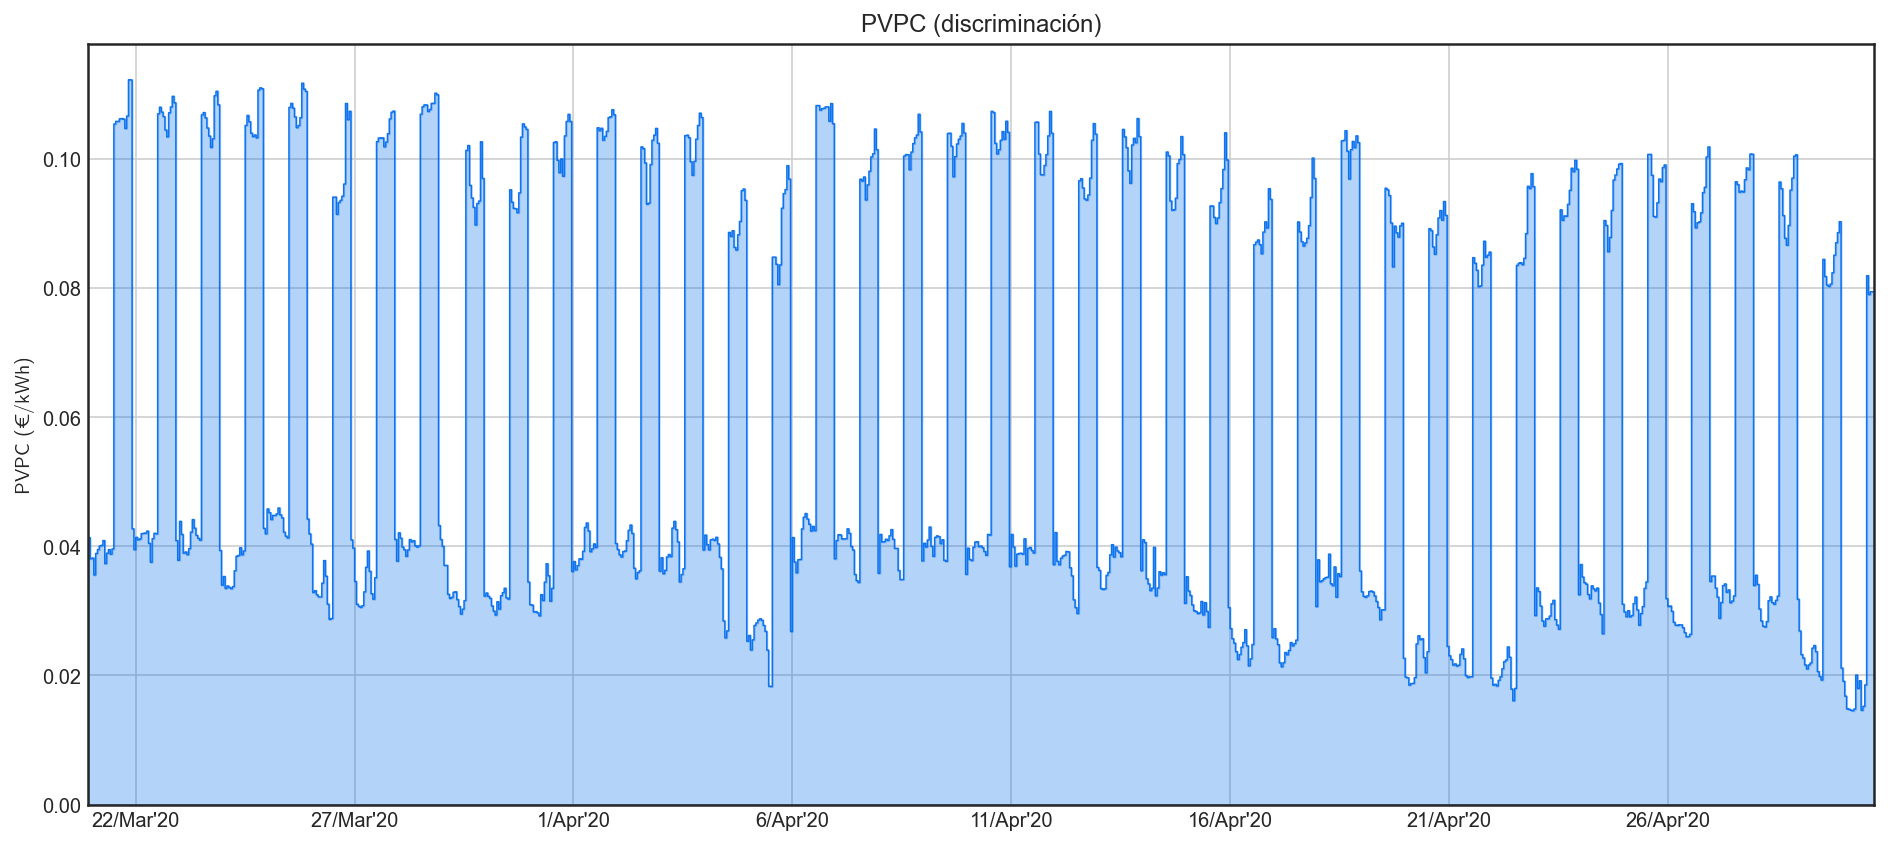

In [4]:
# move to pandas to plot series
s_price_example = pd.Series(prices_range, name="price_€_kWh")
display(s_price_example)

# plot prices
plot_data(
    s_price_example, "PVPC (€/kWh)", "xkcd:cerulean blue",
    figsize=(16, 7),
    tz=REFERENCE_TZ,
    fill_under=True,
    plot_style="seaborn-white",
    date_fmt="%-d/%b\'%y",
    max_xticks=10,
    title="PVPC (discriminación)",
)
plt.show()

### Download full PVPC detailed data in €/MWh

By not using a specific `tariff` in the `PVPCData` handler

In [5]:
full_pvpc_handler = PVPCData()

# download prices in range
start = datetime(2020, 3, 20, 22)
end = datetime(2020, 4, 30, 16)

prices_data: dict = await full_pvpc_handler.async_download_prices_for_range(start, end)

# Example of detailed data
prices_data[min(prices_data)]

Download of 978 prices from 2020-03-20 21:00:00+00:00 to 2020-04-30 14:00:00+00:00 in 0.23 sec


{'GEN': 89.42,
 'NOC': 41.35,
 'VHC': 108.03,
 'COFGEN': 0.000148481953,
 'COFNOC': 0.000182216523,
 'COFVHC': 0.000156872541,
 'PMHGEN': 35.42,
 'PMHNOC': 34.04,
 'PMHVHC': 35.78,
 'SAHGEN': 2.54,
 'SAHNOC': 2.44,
 'SAHVHC': 2.57,
 'FOMGEN': 0.03,
 'FOMNOC': 0.03,
 'FOMVHC': 0.03,
 'FOSGEN': 0.16,
 'FOSNOC': 0.16,
 'FOSVHC': 0.17,
 'INTGEN': 0.04,
 'INTNOC': 0.03,
 'INTVHC': 0.04,
 'PCAPGEN': 5.56,
 'PCAPNOC': 0.93,
 'PCAPVHC': 5.78,
 'TEUGEN': 44.03,
 'TEUNOC': 2.22,
 'TEUVHC': 62.01,
 'CCVGEN': 1.64,
 'CCVNOC': 1.51,
 'CCVVHC': 1.66}

In [6]:
# Move to pandas
df_pvpc = pd.DataFrame(prices_data).T
df_pvpc

,GEN,NOC,VHC,COFGEN,COFNOC,COFVHC,PMHGEN,PMHNOC,PMHVHC,SAHGEN,...,INTVHC,PCAPGEN,PCAPNOC,PCAPVHC,TEUGEN,TEUNOC,TEUVHC,CCVGEN,CCVNOC,CCVVHC
2020-03-20 21:00:00+00:00,89.42,41.35,108.03,0.000148,0.000182,0.000157,35.42,34.04,35.78,2.54,...,0.04,5.56,0.93,5.78,44.03,2.22,62.01,1.64,1.51,1.66
2020-03-20 22:00:00+00:00,86.10,38.08,40.80,0.000124,0.000175,0.000150,31.59,30.30,31.74,3.08,...,0.04,5.58,0.93,1.32,44.03,2.22,2.88,1.59,1.46,1.53
2020-03-20 23:00:00+00:00,86.42,38.19,41.04,0.000098,0.000149,0.000144,31.35,29.97,31.50,3.51,...,0.04,5.68,0.94,1.34,44.03,2.22,2.88,1.61,1.47,1.55
2020-03-21 00:00:00+00:00,83.73,35.57,33.06,0.000079,0.000132,0.000162,28.04,26.79,25.99,4.13,...,0.03,5.71,0.95,0.74,44.03,2.22,0.89,1.58,1.44,1.39
2020-03-21 01:00:00+00:00,87.26,38.90,36.27,0.000068,0.000120,0.000159,31.61,30.18,29.26,4.01,...,0.03,5.74,0.95,0.74,44.03,2.22,0.89,1.64,1.49,1.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30 10:00:00+00:00,65.32,18.54,20.10,0.000122,0.000088,0.000078,11.34,11.00,11.38,3.16,...,0.05,5.32,0.90,1.25,44.03,2.22,2.88,1.24,1.14,1.18
2020-04-30 11:00:00+00:00,63.63,81.92,81.92,0.000128,0.000087,0.000076,9.66,9.73,9.73,3.19,...,0.05,5.30,5.50,5.50,44.03,62.01,62.01,1.21,1.22,1.22
2020-04-30 12:00:00+00:00,60.75,79.01,79.01,0.000125,0.000085,0.000072,6.35,6.39,6.39,3.63,...,0.05,5.33,5.53,5.53,44.03,62.01,62.01,1.18,1.19,1.19
2020-04-30 13:00:00+00:00,61.16,79.44,79.44,0.000116,0.000078,0.000068,6.41,6.46,6.46,3.95,...,0.05,5.36,5.56,5.56,44.03,62.01,62.01,1.18,1.20,1.20


,NOC,PMHNOC,SAHNOC,FOMNOC,FOSNOC,INTNOC,PCAPNOC,TEUNOC,CCVNOC
2020-03-20 21:00:00+00:00,41.35,34.04,2.44,0.03,0.16,0.03,0.93,2.22,1.51
2020-03-20 22:00:00+00:00,38.08,30.30,2.95,0.03,0.16,0.03,0.93,2.22,1.46
2020-03-20 23:00:00+00:00,38.19,29.97,3.35,0.03,0.16,0.04,0.94,2.22,1.47
2020-03-21 00:00:00+00:00,35.57,26.79,3.95,0.03,0.16,0.04,0.95,2.22,1.44
2020-03-21 01:00:00+00:00,38.90,30.18,3.83,0.03,0.16,0.04,0.95,2.22,1.49
...,...,...,...,...,...,...,...,...,...
2020-03-24 16:00:00+00:00,103.72,31.91,2.54,0.03,0.16,0.03,5.49,62.01,1.54
2020-03-24 17:00:00+00:00,103.28,31.55,2.49,0.03,0.16,0.03,5.47,62.01,1.53
2020-03-24 18:00:00+00:00,110.67,39.12,2.14,0.03,0.16,0.03,5.52,62.01,1.65
2020-03-24 19:00:00+00:00,111.02,39.71,1.84,0.03,0.16,0.03,5.56,62.01,1.66


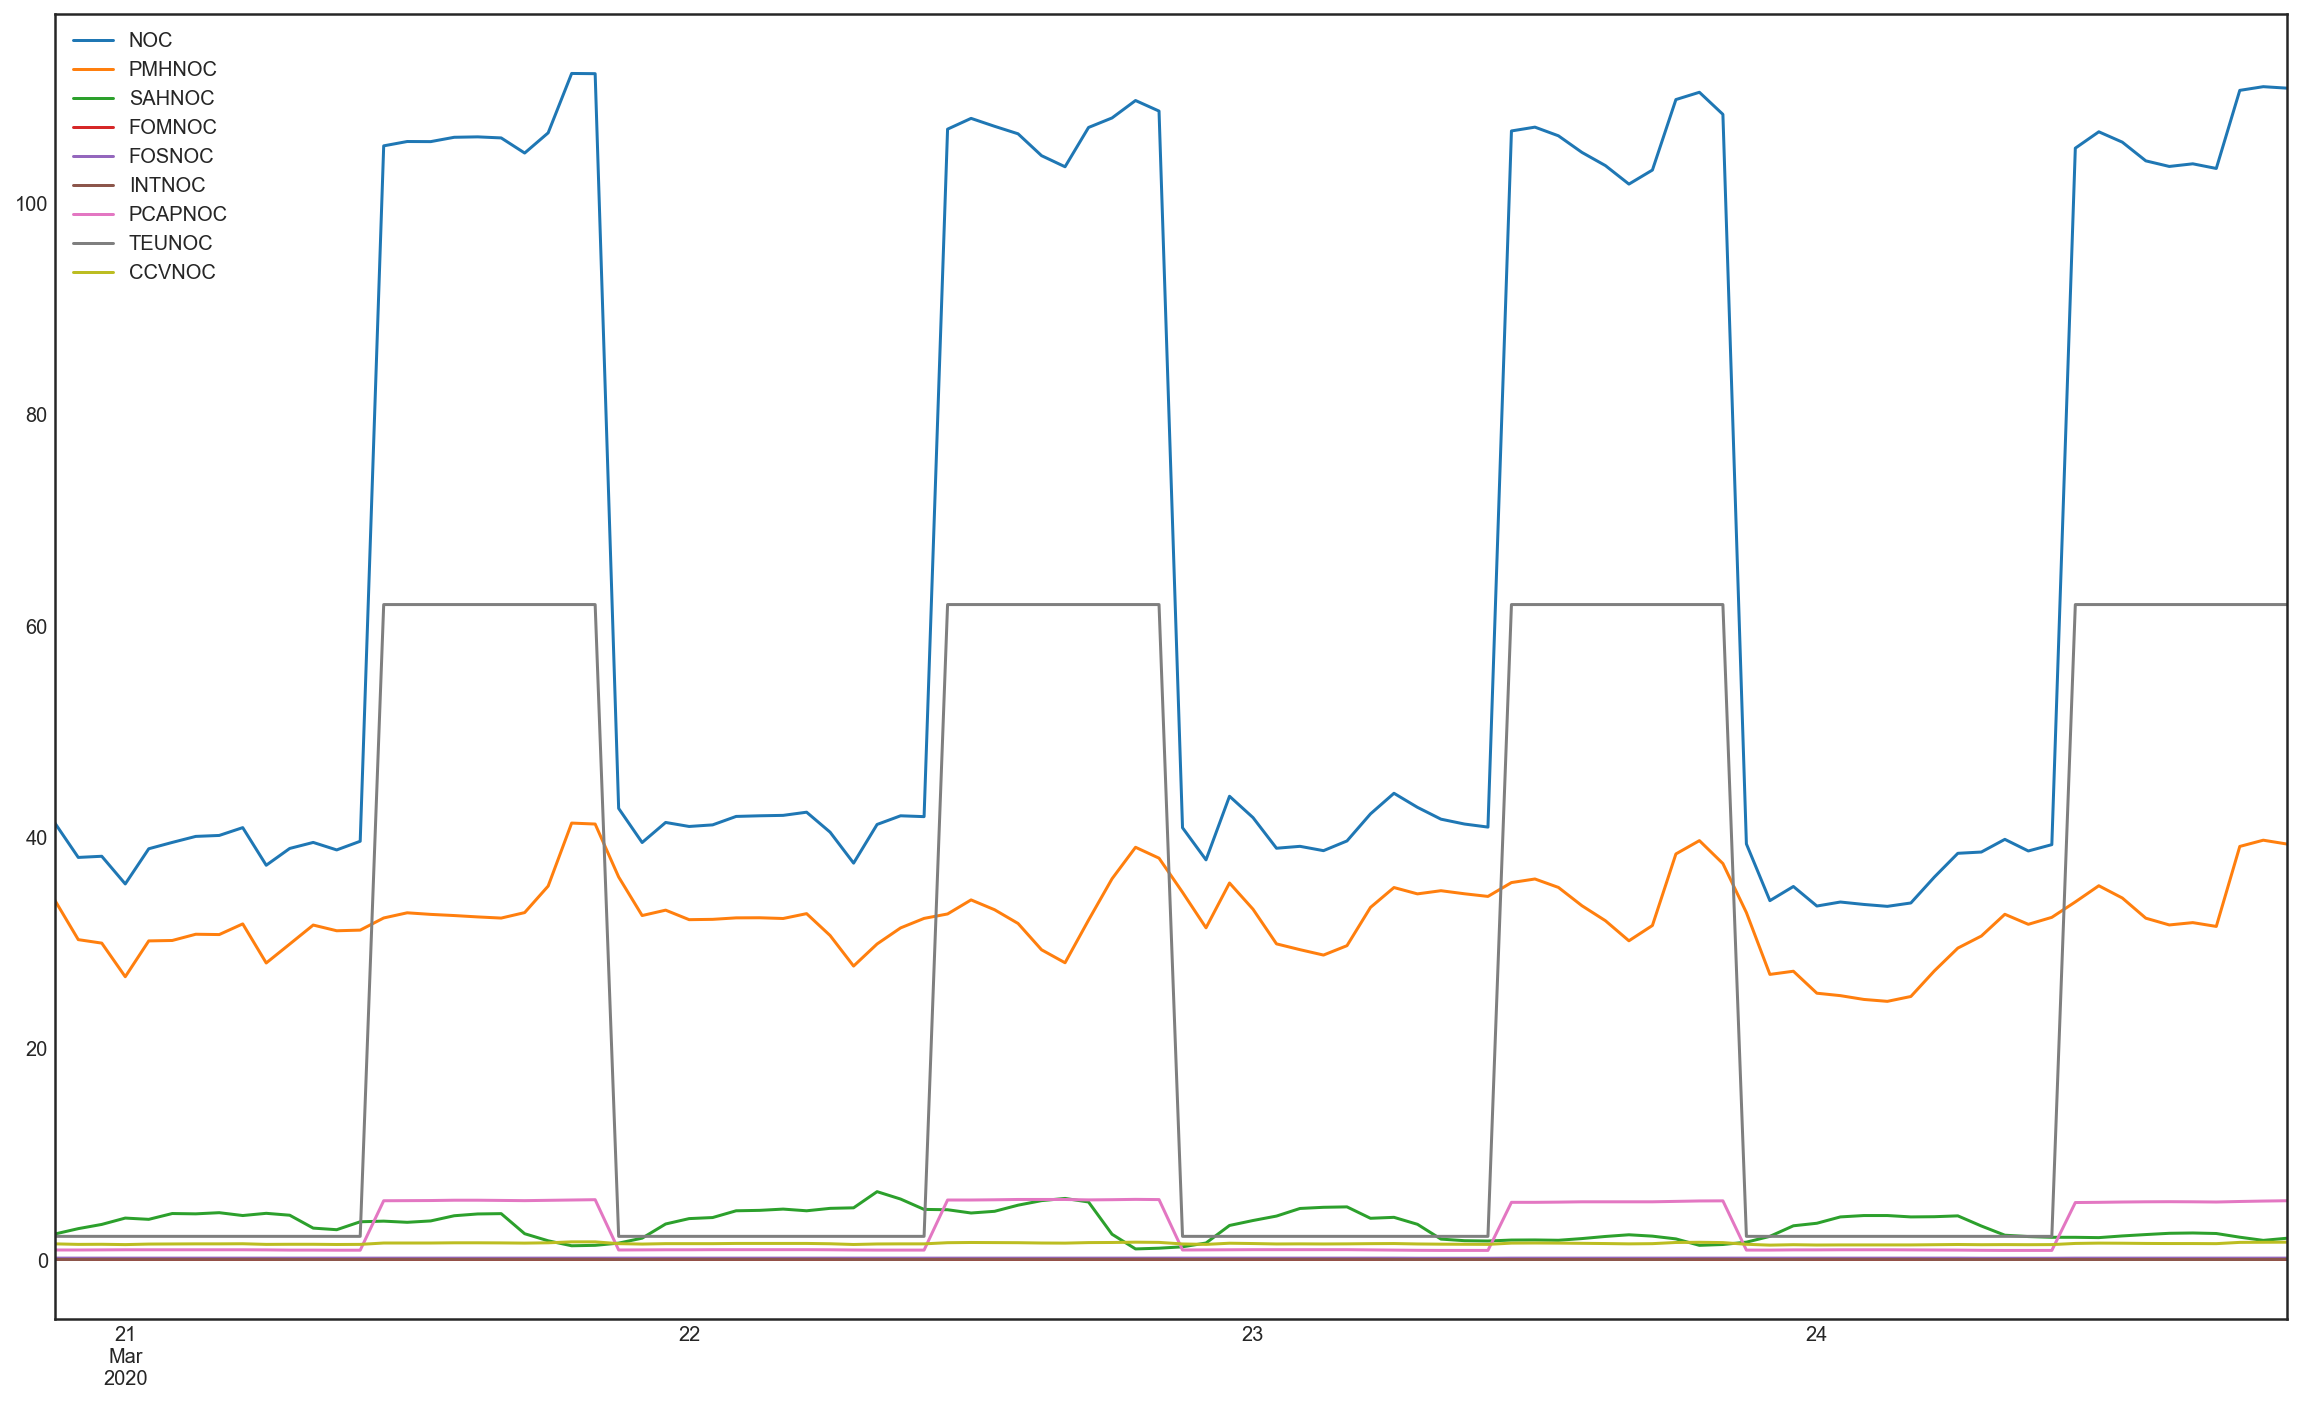

In [7]:
# show some details
subset_noc = df_pvpc.iloc[:96].T[df_pvpc.columns.str.endswith("NOC")].drop("COFNOC").T
display(subset_noc)

subset_noc.plot(figsize=(20, 12));